In [ ]:
###This Jupyter Notebook shows how to query, clean and analyze HVAC data from our database and perform a regression analysis

In [5]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
import seaborn as sns
import psycopg2
import sqlalchemy as sqla
import os
from config.read_config import get_database_config
import numpy as np
import sys
%matplotlib inline
sys.executable  # shows you your path to the python you're using

'/opt/anaconda3/bin/python'

In [6]:
# read in db credentials from config/config.txt
# * make sure you add those to the config/config.txt file! *

database_config = get_database_config("./config/config.txt")

In [7]:
# get our DB connection
engine = sqla.create_engine('postgresql://{}:{}@{}:{}/{}'.format(database_config['username'],
                                                                     database_config['password'],
                                                                     database_config['hostname'],
                                                                     database_config['port'],
                                                                     database_config['database']
                                                                     ))

In [9]:
#query hvac data from homes in TX for April through October 2020
#to get the total electricity consumption related to space conditioning we add all circuits related to the HVAC system in a home
#the specific list of dataids that are used were selected because we know these homes have HVAC circuits individually measured


query_tx = """

SELECT dataid, localhour,
(COALESCE(air1,0) + COALESCE(air2,0) + COALESCE(air3,0) + COALESCE(furnace1,0) + COALESCE(furnace2,0) +COALESCE(heater1,0) +COALESCE(heater2,0) +COALESCE(heater3,0) +COALESCE(airwindowunit1,0)) AS HVAC_use
 
FROM electricity.eg_realpower_1hr
WHERE dataid IN (5746, 59, 86, 93, 94, 101, 153, 171, 186, 379, 410, 483, 499, 503, 545, 661, 668, 744, 796, 946, 994, 1086, 1103, 1169, 1267, 1283, 1354, 1517, 1551, 1641, 1642, 1714, 1947, 1970, 2018, 2094, 2153, 2158, 2199, 2233, 2335, 2361, 2378, 2442, 2461, 2470, 2611, 2791, 2811, 2814, 2818, 2859, 2945, 2986, 3009, 3029, 3039, 3134, 3310, 3392, 3413, 3456, 3482, 3500, 3506, 3538, 3715, 3719, 3723, 3736, 3778, 3829, 3831, 3849, 3893, 3967, 4031, 4090, 4193, 4213, 4298, 4336, 4352, 4356, 4448, 4514, 4526, 4565, 4580, 4633, 4732, 4767, 4874, 4894, 4970, 4998, 5109, 5317, 5357, 5371, 5403, 5450, 5545, 5615, 5656, 5658, 5677, 5715, 5746, 5749, 5763, 5784, 5929, 5949, 5959, 5972, 6063, 6121, 6139, 6248, 6348, 6390, 6487, 6498, 6558, 6578, 6691, 6692, 6836, 7017, 7429, 7504, 7536, 7541, 7627, 7660, 7678, 7680, 7690, 7719, 7731, 7739, 7769, 7793, 7800, 7850, 7973, 7989, 8084, 8086, 8142, 8174, 8198, 8236, 8278, 8282, 8292, 8317, 8386, 8645, 8767, 8829, 8847, 8857, 8967, 8992, 8995, 9141, 9160, 9237, 9278, 9295, 9484, 9609, 9729, 9875, 9912, 9922, 9926, 9932, 9934, 9937, 9942, 9956, 9971, 10488, 8857, 8967, 8992, 8995, 9141, 9160, 9237, 9278, 9295, 9484, 9609, 9729, 9875, 9912, 9922, 9926, 9932, 9934, 9937, 9942, 9956, 9971, 10488
                )
AND localhour > '2020-04-01 00:00:00-06'
AND  localhour < '2020-11-01 00:00:00-06'

"""
df_hvac_tx = pd.read_sql_query(sqla.text(query_tx), engine)

In [10]:
df_hvac_tx

,dataid,localhour,hvac_use
0,59,2020-04-01 07:00:00+00:00,0.059
1,59,2020-04-01 08:00:00+00:00,0.059
2,59,2020-04-01 09:00:00+00:00,0.059
3,59,2020-04-01 10:00:00+00:00,0.058
4,59,2020-04-01 11:00:00+00:00,0.058
...,...,...,...
943857,10488,2020-11-01 01:00:00+00:00,0.127
943858,10488,2020-11-01 02:00:00+00:00,0.134
943859,10488,2020-11-01 03:00:00+00:00,0.026
943860,10488,2020-11-01 04:00:00+00:00,0.026


In [11]:
#query hvac data from homes in NY for April through October 2020
#to get the total electricity consumption related to space conditioning we add all circuits related to the HVAC system in a home
#the specific list of dataids that are used were selected because we know these homes have HVAC circuits individually measured

query_ny = """

SELECT dataid, localhour,
(COALESCE(air1,0) + COALESCE(air2,0) + COALESCE(air3,0) + COALESCE(furnace1,0) + COALESCE(furnace2,0) +COALESCE(heater1,0) +COALESCE(heater2,0) +COALESCE(heater3,0) +COALESCE(airwindowunit1,0)) AS HVAC_use

FROM electricity.eg_realpower_1hr
WHERE dataid IN (3403, 6564, 7999, 9002, 9004, 9973, 10089, 10164, 10182, 10202, 10554, 10983, 335, 690, 950, 1240, 1249, 1417, 2164, 3000, 3488, 3996, 4414, 4550, 5058, 5192, 5587, 5679, 6172, 6526, 6594, 6703, 7021, 8577, 8849, 9002, 9004, 9973, 10089, 10164, 10182, 10202, 10554, 10983 --NY HOMES 
                )
AND localhour > '2020-04-01 00:00:00-06'
AND  localhour < '2020-11-01 00:00:00-06'
                    
                     """
df_hvac_ny = pd.read_sql_query(sqla.text(query_ny), engine)

In [12]:
df_hvac_ny

,dataid,localhour,hvac_use
0,335,2020-04-01 07:00:00+00:00,0.122
1,335,2020-04-01 08:00:00+00:00,0.124
2,335,2020-04-01 09:00:00+00:00,0.342
3,335,2020-04-01 10:00:00+00:00,0.132
4,335,2020-04-01 11:00:00+00:00,0.132
...,...,...,...
179697,10983,2020-11-01 01:00:00+00:00,0.020
179698,10983,2020-11-01 02:00:00+00:00,0.057
179699,10983,2020-11-01 03:00:00+00:00,0.088
179700,10983,2020-11-01 04:00:00+00:00,0.070


In [13]:
#convert the date to a datetime and set it as the index in both of the dataframes

df_hvac_ny['localhour'] = pd.to_datetime(df_hvac_ny['localhour'], utc=True)
df_hvac_ny.set_index('localhour', inplace=True)

df_hvac_tx['localhour'] = pd.to_datetime(df_hvac_tx['localhour'], utc=True)
df_hvac_tx.set_index('localhour', inplace=True)

In [14]:
#read in temperature files for Austin, TX and Ithaca, NY
#drop unwanted columns
#convert the date to a datetime and set it as the index in both of the dataframes

df_ny_temp = pd.read_csv('/Users/cavanmerski/Desktop/Sloan Analysis/Sloan 2.0 Analysis Files/FINAL MERGE FILES/check timestamps/DB_temp_data_ithaca.csv')
df_ny_temp['localhour'] = pd.to_datetime(df_ny_temp['localhour'], utc=True)
df_ny_temp.drop(['irradiance', 'longitude'], axis=1, inplace=True)
df_ny_temp.set_index('localhour', inplace=True)

df_tx_temp = pd.read_csv('/Users/cavanmerski/Desktop/Sloan Analysis/Sloan 2.0 Analysis Files/FINAL MERGE FILES/check timestamps/DB_temp_data_austin.csv')
df_tx_temp['localhour'] = pd.to_datetime(df_tx_temp['localhour'], utc=True)
df_tx_temp.drop(['irradiance', 'longitude'], axis=1, inplace=True)
df_tx_temp.set_index('localhour', inplace=True)

In [15]:
#merge hvac consumption and temperature files for both locations

df_m1_ny = pd.merge(df_hvac_ny, df_ny_temp, left_index=True, right_index = True, how='left')
df_m1_ny['temperature'].dropna(inplace=True)

df_m1_tx = pd.merge(df_hvac_tx, df_tx_temp, left_index=True, right_index = True, how='left')
df_m1_tx['temperature'].dropna(inplace=True)

In [16]:
#concat dataframes for Austin and Ithaca into one dataframe
#cast dataid as a string and reset the index

ny_tx = [df_m1_tx, df_m1_ny]
df_final_dataset = pd.concat(ny_tx)
df_final_dataset['dataid'] = df_final_dataset['dataid'].astype('str')
df_final_dataset = df_final_dataset.reset_index()

In [91]:
#query the square footage for homes in our network
query_tx = """

SELECT dataid, mailing_state, total_square_footage
FROM do_not_use.participant_info

"""
df_participant_info = pd.read_sql_query(sqla.text(query_tx), engine)

In [92]:
#match data types in preparation for merging data and drop unwanted columns
#round temperature values to one decimal point

df_participant_info.dropna(inplace=True)
df_participant_info['dataid'] = df_participant_info['dataid'].astype(int).astype(str)
df_merged_part_info = pd.merge(df_final_dataset, df_participant_info,left_on=df_final_dataset["dataid"], right_on = df_participant_info['dataid'], how='left')
df_merged_part_info.drop(['key_0', 'dataid_y'], axis=1, inplace=True)
df_merged_part_info = df_merged_part_info.round({'temperature': 1})
df_merged_part_info

,localhour,dataid_x,hvac_use,latitude,temperature,mailing_state,total_square_footage
0,2020-04-01 07:00:00+00:00,59,0.059,30.292432,53.6,Texas,3825.0
1,2020-04-01 07:00:00+00:00,86,0.012,30.292432,53.6,Texas,1788.0
2,2020-04-01 07:00:00+00:00,93,0.069,30.292432,53.6,Texas,2934.0
3,2020-04-01 07:00:00+00:00,94,0.033,30.292432,53.6,Texas,1713.0
4,2020-04-01 07:00:00+00:00,101,0.057,30.292432,53.6,Texas,1459.0
...,...,...,...,...,...,...,...
1123559,2020-11-01 05:00:00+00:00,10164,0.418,42.421658,34.9,New York,1267.0
1123560,2020-11-01 05:00:00+00:00,10182,0.020,42.421658,34.9,New York,2156.0
1123561,2020-11-01 05:00:00+00:00,10202,0.010,42.421658,34.9,New York,1782.0
1123562,2020-11-01 05:00:00+00:00,10554,0.086,42.421658,34.9,New York,1206.0


In [104]:
#only look at temperatures above 70 degrees when we would expect AC to be on

df_base_regression = df_merged_part_info
df_base_regression = df_base_regression[df_base_regression.temperature > 69.9]


In [107]:
#create new dataframe with only the columns we need for the temp vs. avg HVAC regression

reg_1 = df_base_regression[['dataid_x', 'total_square_footage', 'hvac_use', 'mailing_state', 'temperature']]
reg_1.reset_index(drop=True, inplace=True)
reg_1 = reg_1.groupby(by=['mailing_state', 'temperature'], as_index=False).mean()
reg_1 = reg_1.rename(columns={'mailing_state': 'State'})


In [108]:
reg_1_tx = reg_1[reg_1.State == 'Texas']
reg_1_ny = reg_1[reg_1.State == 'New York']

reg_1_tx = reg_1_tx.dropna()
reg_1_tx.reset_index(drop=True, inplace=True)

reg_1_ny = reg_1_ny.dropna()
reg_1_ny.reset_index(drop=True, inplace=True)

In [100]:

result_poly = smf.ols('hvac_use ~ temperature +' + 'I(temperature**2) +' + 'I(temperature**3)', data=reg_1_tx).fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:               hvac_use   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.078e+04
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          7.47e-318
Time:                        23:46:37   Log-Likelihood:                 382.28
No. Observations:                 320   AIC:                            -756.6
Df Residuals:                     316   BIC:                            -741.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              29.3040    

In [109]:
result_poly = smf.ols('hvac_use ~ temperature +' + 'I(temperature**2) +' + 'I(temperature**3)', data=reg_1_ny).fit()
print(result_poly.summary())


                            OLS Regression Results                            
Dep. Variable:               hvac_use   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     882.5
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          2.10e-115
Time:                        23:56:05   Log-Likelihood:                 212.51
No. Observations:                 205   AIC:                            -417.0
Df Residuals:                     201   BIC:                            -403.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              56.2035    

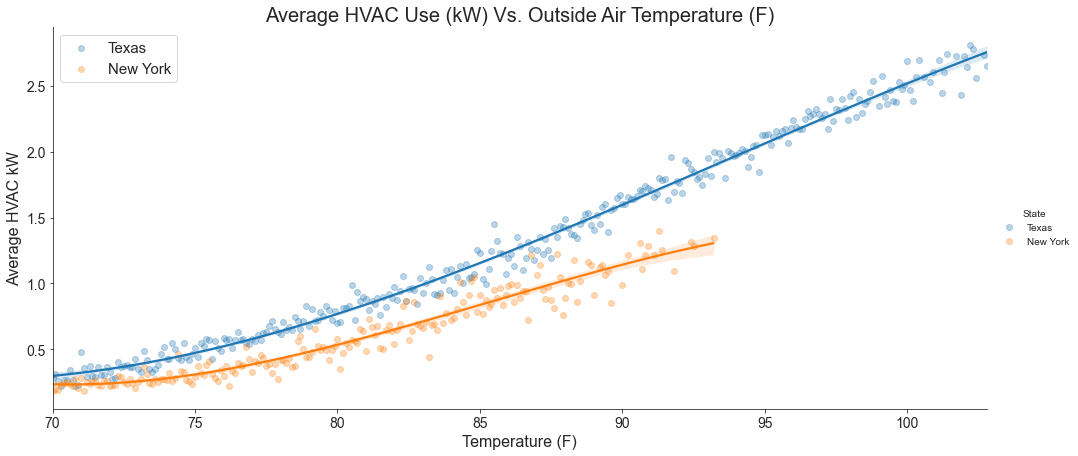

In [111]:
#create a plot of the HVAC Use (kW) vs. Outside Air Temprature with the polynomial regression line in Seaborn

sns.set_style('ticks')
sns.set_font_scale=15

sns.lmplot(x='temperature', y='hvac_use', data=reg_1,  scatter_kws={'alpha':0.3}, order=3,  
hue ='State',  hue_order = ['Texas', 'New York'],  height=6, aspect=2.3)
plt.xlabel('Temperature (F)', fontsize=16);
plt.ylabel('Average HVAC kW', fontsize=16);
plt.title('Average HVAC Use (kW) Vs. Outside Air Temperature (F)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=15)


In [124]:
reg_2 = df_base_regression[['dataid_x', 'total_square_footage', 'hvac_use', 'mailing_state']]
reg_2.reset_index(drop=True, inplace=True)
reg_2 = reg_2.groupby(by=['mailing_state', 'dataid_x'], as_index=False).mean()
reg_2 = reg_2.rename(columns={'mailing_state': 'State'})


In [122]:
#perform linear regression analysis on home square footage vs. average HVAC kW draw in the summer months. There isn't a strong relationship between these two variables
result_poly = smf.ols('hvac_use ~ total_square_footage', data=reg_2).fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:               hvac_use   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     36.90
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           5.62e-09
Time:                        11:47:35   Log-Likelihood:                -134.08
No. Observations:                 216   AIC:                             272.2
Df Residuals:                     214   BIC:                             278.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.4532 

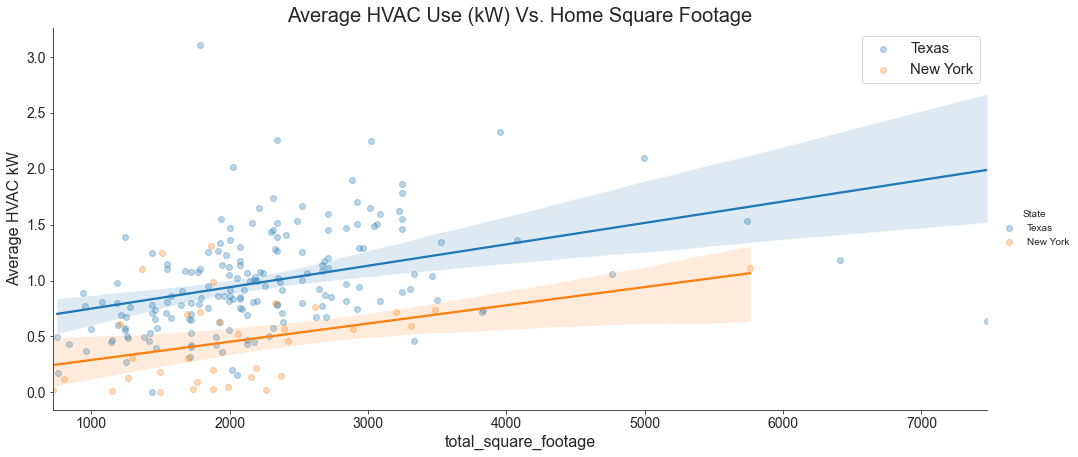

In [114]:
#create scatterplot showing relationship between home size in square feet and the average summer HVAC kW

sns.set_style('ticks')
sns.set_font_scale=15

sns.lmplot(x='total_square_footage', y='hvac_use', data=reg_2,  scatter_kws={'alpha':0.3}, order=1,  
hue ='State',  hue_order = ['Texas', 'New York'],  height=6, aspect=2.3)
plt.xlabel('total_square_footage', fontsize=16);
plt.ylabel('Average HVAC kW', fontsize=16);
plt.title('Average HVAC Use (kW) Vs. Home Square Footage', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=15)